In [1]:
# Import modules
%matplotlib inline
import math
import numpy as np
import pandas as pd
from scipy.special import expit
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import sys
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

Using TensorFlow backend.


In [9]:
def initialize_weights(input_matrix, label_matrix, hidden_layer_stats=None, scaled_by = None):
    '''
    hidden_layer_stats = <List of layer dimensions>
    '''
    if not scaled_by:
        scaled_by = math.sqrt(2. / input_matrix.shape[0])
    input_n = input_matrix.shape[1]
    output_n = label_matrix.shape[1]
    if not hidden_layer_stats or not len(hidden_layer_stats):
        return [(np.random.rand(input_n+1, output_n) - .5) * scaled_by]
    else:
        weights = []
        weights.append((np.random.rand(input_n+1, hidden_layer_stats[0]) - .5) * scaled_by)
        for i in range(len(hidden_layer_stats) - 1):
            now_dim = hidden_layer_stats[i]
            next_dim = hidden_layer_stats[i+1]
            weights.append((np.random.rand(now_dim+1, next_dim) - .5) * scaled_by)
        weights.append((np.random.rand(hidden_layer_stats[-1]+1, output_n) - .5) * scaled_by)
        return weights

def net(weight_matrix, prev_matrix):
    return prev_matrix.dot(weight_matrix)

# sigmoid
def output_activation(net_matrix):
    return expit(net_matrix)

# relu
def activation(net_matrix):
    return expit(net_matrix)
    net_matrix[net_matrix < 0] = 0
    return net_matrix

# propagate once to set up value_matrices
def forward_propagate_once(input_matrix, weights, value_matrices):
    del value_matrices[:]
    prev_matrix = input_matrix
    prev_matrix = np.concatenate((prev_matrix, np.ones_like(prev_matrix[:, -1]).reshape(-1,1)), axis=1)
    value_matrices.append(prev_matrix)
    
    # propagate using given activation function in the hidden layers
    for i in range(len(weights)-1):
        prev_matrix = activation(net(weights[i], prev_matrix))
        prev_matrix = np.concatenate((prev_matrix, np.ones_like(prev_matrix[:, -1]).reshape(-1,1)), axis=1)
        value_matrices.append(prev_matrix)
    
    # propagate using output activation function for output
    prev_matrix = output_activation(net(weights[-1], prev_matrix))
    value_matrices.append(prev_matrix)

# forward propagate updates
def forward_propagate(weights, value_matrices):
    for i in range(len(weights)-1):
        value_matrices[i+1][:, :-1] = activation(net(weights[i], value_matrices[i]))
    value_matrices[-1] = output_activation(net(weights[-1], value_matrices[-2]))

# forward propagate to generate output matrix
def forward_propagate_output(weights, input_matrix):
    output_matrix = np.concatenate((input_matrix, np.ones_like(input_matrix[:, -1]).reshape(-1,1)), axis=1)
    for i in range(len(weights)-1):
        output_matrix = activation(net(weights[i], output_matrix))
        output_matrix = np.concatenate((output_matrix, np.ones_like(output_matrix[:, -1]).reshape(-1,1)), axis=1)
    output_matrix = output_activation(net(weights[-1], output_matrix))
    return output_matrix

def forward_propagate_layer(weights, input_matrix, layer):
    '''layer: hidden layer number (0-based)'''
    output_matrix = np.concatenate((input_matrix, np.ones_like(input_matrix[:, -1]).reshape(-1,1)), axis=1)
    for i in range(layer):
        output_matrix = activation(net(weights[i], output_matrix))
        output_matrix = np.concatenate((output_matrix, np.ones_like(output_matrix[:, -1]).reshape(-1,1)), axis=1)
    output_matrix = activation(net(weights[layer], output_matrix))
    return output_matrix

def cost(value_matrices, weights, label_matrix, n_records, regularization_lambda, name='mse'):
    reg_term = sum([(w**2).sum() for w in weights]) / (2*n_records)
    if name == 'mse':
        return ((value_matrices[-1] - label_matrix)**2).sum() / (2*n_records) + regularization_lambda*reg_term
    if name == 'entropy':
        return (-label_matrix * np.log(value_matrices[-1]) - (1-label_matrix) * np.log(1-value_matrices[-1])).sum() / n_records + regularization_lambda*reg_term
    raise Exception('cost function %s not supported' %name)

def backprop_update_weights(value_matrices, weights, label_matrix, n_records, learning_rate, regularization_lambda):
    '''output: sigmoid; hidden layers: relu; cost: mse'''
    delta = (value_matrices[-1] - label_matrix) * value_matrices[-1] * (1-value_matrices[-1])
    step = learning_rate * (delta.T.dot(value_matrices[-2]) / n_records).T
    
    if len(weights) > 1:
        delta = delta.dot(weights[-1].T) * value_matrices[-2] * (1 - value_matrices[-2])
        weights[-1][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[-1][:-1, :]
        step = learning_rate * (delta[:, :-1].T.dot(value_matrices[-3]) / n_records).T
    
    for i in range(len(weights)-2, 0, -1):
        delta = delta[:, :-1].dot(weights[i].T) * value_matrices[i] * (1 - value_matrices[i])
        weights[i][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[i][:-1, :]
        step = learning_rate * (delta[:, :-1].T.dot(value_matrices[i-1]) / n_records).T
    
    weights[0][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[0][:-1, :]

def cluster_backprop_update_weights(value_matrices, weights, label_matrix, n_records, learning_rate, regularization_lambda, code_layer_idx, centers, cluster_param=1):
    '''output: sigmoid; hidden layers: relu; cost: mse'''
    delta = (value_matrices[-1] - label_matrix) * value_matrices[-1] * (1-value_matrices[-1])
    step = learning_rate * (delta.T.dot(value_matrices[-2]) / n_records).T
    
    if len(weights) > 1:
        delta = delta.dot(weights[-1].T) * value_matrices[-2] * (1 - value_matrices[-2])
        weights[-1][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[-1][:-1, :]
        if code_layer_idx == len(value_matrices) - 2:
            raise Exception('Not supported.')
            delta += (value_matrices[-2] - centers) * value_matrices[-2] * (1 - value_matrices[-2])
        step = learning_rate * (delta[:, :-1].T.dot(value_matrices[-3]) / n_records).T
    
    for i in range(len(weights)-2, 0, -1):
        delta = delta[:, :-1].dot(weights[i].T) * value_matrices[i] * (1 - value_matrices[i])
        weights[i][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[i][:-1, :]
        if code_layer_idx == i:
            delta += cluster_param * (value_matrices[i] - centers) * value_matrices[i] * (1 - value_matrices[i]) * 10
        step = learning_rate * (delta[:, :-1].T.dot(value_matrices[i-1]) / n_records).T
    
    weights[0][:-1, :] -= step[:-1, :] + regularization_lambda / n_records * weights[0][:-1, :]

def grad_check(i, j, k, input_matrix, label_matrix, weights, n_records, regularization_lambda, h=1e-6):
    value_matrices = []
    forward_propagate_once(input_matrix, weights, value_matrices)
    
    # numerical gradient for weight_jk in ith layer
    perturbed_weights = ([w.copy() for w in weights], [w.copy() for w in weights])
    value_matrices_copies = ([m.copy() for m in value_matrices], [m.copy() for m in value_matrices])
    perturbed_weights[0][i][j, k] -= h
    perturbed_weights[1][i][j, k] += h
    forward_propagate(perturbed_weights[0], value_matrices_copies[0])
    forward_propagate(perturbed_weights[1], value_matrices_copies[1])
    cost_diff = cost(value_matrices_copies[1], weights, label_matrix, n_records, regularization_lambda) - cost(value_matrices_copies[0], weights, label_matrix, n_records, regularization_lambda)
    numerical_grad = cost_diff / (2*h)
    weights_copy = [w.copy() for w in weights]
    weight_before = weights_copy[i][j, k]
    backprop_update_weights(value_matrices, weights_copy, label_matrix, n_records, 1, regularization_lambda)
    weight_after = weights_copy[i][j, k]
    print('The gradient in backpropagation is %.16f\nThe numerical gradient is %.16f\nThe difference is %.16f' % (weight_before-weight_after, numerical_grad, (weight_before-weight_after)-numerical_grad))

def print_info(fit_info, i, j):
    if abs(fit_info['prev_cost'] - fit_info['now_cost']) < fit_info['threshold']:
        print('Neural network weights have converged after %d iterations.' % (i+1))
        return 0
    if not fit_info['mute']:
        if j is None:
            print('\r', 'Step %d: Cost=%f, Delta Cost=%f' % (i+1, fit_info['now_cost'], abs(fit_info['prev_cost'] - fit_info['now_cost'])), end='')
        else:
            print('\r', 'Epoch %d (Batch %d): Cost=%f, Delta Cost=%f' % (i+1, j+1, fit_info['now_cost'], abs(fit_info['prev_cost'] - fit_info['now_cost'])), end='')
    fit_info['prev_cost'] = fit_info['now_cost']

def fit_step(weights, value_matrices, label_matrix, fit_info, i, j=None):
    forward_propagate(weights, value_matrices)
    backprop_update_weights(value_matrices, weights, label_matrix, label_matrix.shape[0], fit_info['learning_rate'], fit_info['regularization_lambda'])
    fit_info['now_cost'] = cost(value_matrices, weights, label_matrix, fit_info['n_records'], fit_info['regularization_lambda'])
    print_info(fit_info, i, j)

def cluster_fit_step(code_layer_idx, centers, idx_range, weights, value_matrices, label_matrix, fit_info, i, j, cluster_param):
    forward_propagate(weights, value_matrices)
    
    ### backprop step ###
    code_layer = value_matrices[code_layer_idx]
    closest_idx = closest_centers_idx(code_layer, centers)
    cluster_backprop_update_weights(value_matrices, weights, label_matrix, label_matrix.shape[0], fit_info['learning_rate'], fit_info['regularization_lambda'], code_layer_idx, centers[closest_idx, :], cluster_param)
    fit_info['now_cost'] = cost(value_matrices, weights, label_matrix, fit_info['n_records'], fit_info['regularization_lambda'])
    print_info(fit_info, i, j)

def trainNN(input_matrix, label_matrix, weights, centers, code_layer_idx, max_itr=10000, threshold=1e-6, learning_rate=.1, regularization_lambda = .1, mute=True, minibatch=True, cluster_param=1):
    '''Update weights in-place'''
    N0 = N = input_matrix.shape[0]
    value_matrices = value_matrices_full_data = []
    if minibatch:
        N = min(100, N)
        forward_propagate_once(input_matrix, weights, value_matrices_full_data) # for use in minibatch clustering
    forward_propagate_once(input_matrix[:N, :], weights, value_matrices)

    fit_info = {
        'prev_cost': cost(value_matrices, weights, label_matrix[:N, :], N, regularization_lambda),
        'now_cost': None,
        'N0': N0,
        'n_records': N,
        'learning_rate': learning_rate,
        'regularization_lambda': regularization_lambda,
        'mute': mute,
        'threshold': threshold
    }
    
    # for clustering
    n_clusters = centers.shape[0]
    centers[:, ] = value_matrices[code_layer_idx][np.random.choice(N, n_clusters, replace=False), :]
    idx_range = np.arange(n_clusters)

    for i in range(max_itr):
        np.random.seed(i)
        rd_idx = np.random.permutation(range(input_matrix.shape[0]))
        input_matrix = input_matrix[rd_idx, :]
        label_matrix = label_matrix[rd_idx, :]
        
        if minibatch and N0 > N:
            '''Use only multiples of N records (leave the last remaining records out of training for each epoch)'''
            iter_i=0

            forward_propagate(weights, value_matrices_full_data)

            ### K-Means step ###
            code_layer = value_matrices_full_data[code_layer_idx]
            # assignment
            closest_idx = closest_centers_idx(code_layer, centers)
            # compute centers
            compute_centers(code_layer, closest_idx, idx_range, centers)
            
            while (iter_i+1)*N<N0:
                value_matrices[0][:, :-1] = input_matrix[iter_i*N:(iter_i+1)*N, :]
                cluster_fit_step(code_layer_idx, centers, idx_range, weights, value_matrices, label_matrix[iter_i*N:(iter_i+1)*N, :], fit_info, i, iter_i, cluster_param)
                iter_i+=1
            print()
        else:
            forward_propagate_once(input_matrix, weights, value_matrices)
            if not fit_info['prev_cost']:
                fit_info['prev_cost'] = cost(value_matrices, weights, label_matrix, N0, regularization_lambda)
            cluster_fit_step(code_layer_idx, centers, idx_range, weights, value_matrices, label_matrix, fit_info, i)
            print()
    print('\n%d iterations of training completed.' % max_itr)
    return 1

In [3]:
def closest_centers_idx(data, centers):
    '''
    find the closest center for each record in the data by euclidean distance
    n_clusters: centers.shape[0]
    
    axis 0: record
    axis 1: n_cluster copies
    axis 2: features (columns)
    '''
    rep_data = np.swapaxes(np.broadcast_to(data, (centers.shape[0],) + data.shape), 0, 1)
    sum_of_squares = ((rep_data - centers) ** 2).sum(axis=2)
    idx = np.argmin(sum_of_squares, axis = 1)
    # return centers[idx, :]
    return idx

In [4]:
def compute_centers(data, idx, idx_range, centers):
    '''After weights are updated'''
    idx_reps = np.swapaxes(np.broadcast_to(idx, idx_range.shape + idx.shape), 0, 1)
    data_reps = np.swapaxes(np.broadcast_to(data, idx_range.shape + data.shape), 0, 2)
    tf = idx_reps == idx_range
    centroid_sums = np.swapaxes(data_reps * tf, 0, 2).sum(axis=1)
    divisor = tf.sum(axis=0)
    to_assign = centroid_sums[divisor>0, :] / divisor[divisor>0].reshape(-1, 1)
    if (to_assign.shape[0] - centers.shape[0] == 0):
        centers[:, :] = to_assign
    else:
        pass
        # if some centers disappear, do not change centers

### MNIST test

In [7]:
from mnist import MNIST
enc = OneHotEncoder(sparse=False)

mndata = MNIST('./MNIST')
train_X_0, train_y_0 = mndata.load_training()
train_pixels = np.array([np.array(pixels).reshape(28, 28) for pixels in train_X_0])

test_X_0, test_y_0 = mndata.load_testing()
test_pixels = np.array([np.array(pixels).reshape(28, 28) for pixels in test_X_0])

train_X = np.array(train_X_0)
enc.fit(np.array(train_y_0).reshape(-1, 1))
train_y = enc.transform(np.array(train_y_0).reshape(-1, 1))

test_X = np.array(test_X_0)
test_y = enc.transform(np.array(test_y_0).reshape(-1, 1))

def show_digit(pixels, idx):
    plt.imshow(pixels[idx], cmap='gray')
    plt.show()

In [8]:
def get_train_test_acc():
    print('Train accuracy: %.4f' % (sum(map(lambda x: x[0] == x[1], zip(forward_propagate_predict(weights, train_X_scaled).tolist(), train_y_0))) / len(train_y_0)))
    print('Testing accuracy: %.4f' % (sum(map(lambda x: x[0] == x[1], zip(forward_propagate_predict(weights, test_X_scaled).tolist(), test_y_0))) / len(test_y_0)))

In [16]:
train_X = train_X.astype(np.float32)
test_X = test_X.astype(np.float32)

scaler = MinMaxScaler()
scaler.fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

weights = initialize_weights(train_X_scaled, train_X_scaled, scaled_by=1, hidden_layer_stats = (50, 10, 50))
centers = np.zeros((10, 11))

In [26]:
from time import time
start = time()
trainNN(train_X_scaled, train_X_scaled, weights, centers, 2, mute=False, max_itr=100, learning_rate=.1, regularization_lambda=.01, threshold=1e-16, minibatch=True, cluster_param=1)
print('Time: %.4f' % (time() - start))

 Epoch 1 (Batch 599): Cost=20.409125, Delta Cost=0.389347
 Epoch 2 (Batch 599): Cost=21.092810, Delta Cost=1.482961
 Epoch 3 (Batch 599): Cost=21.061871, Delta Cost=1.301125
 Epoch 4 (Batch 599): Cost=20.578590, Delta Cost=1.271523
 Epoch 5 (Batch 599): Cost=19.631238, Delta Cost=0.239660
 Epoch 6 (Batch 599): Cost=19.744847, Delta Cost=0.659516
 Epoch 7 (Batch 599): Cost=20.082922, Delta Cost=1.252547
 Epoch 8 (Batch 599): Cost=19.349616, Delta Cost=0.875068
 Epoch 9 (Batch 599): Cost=18.920134, Delta Cost=0.382335
 Epoch 10 (Batch 599): Cost=18.456595, Delta Cost=0.494541
 Epoch 11 (Batch 599): Cost=18.410915, Delta Cost=0.529094
 Epoch 12 (Batch 599): Cost=17.872065, Delta Cost=0.249342
 Epoch 13 (Batch 599): Cost=16.935683, Delta Cost=0.325529
 Epoch 14 (Batch 599): Cost=15.764326, Delta Cost=1.677517
 Epoch 15 (Batch 599): Cost=17.028347, Delta Cost=0.121758
 Epoch 16 (Batch 599): Cost=16.396213, Delta Cost=0.470920
 Epoch 17 (Batch 599): Cost=15.113335, Delta Cost=1.109303
 Epoch

* Gradient check for correctness of backpropagation

In [21]:
grad_check(2, 0, 32, train_X_scaled, train_X_scaled, weights, 60000, .01, h=1e-6)

The gradient in backpropagation is -0.0019537438667466
The numerical gradient is -0.0019538841655731
The difference is 0.0000001402988264


In [12]:
# Random image
def predict_random(test_X_scaled, test_pixels):
    idx = np.random.choice(test_X_scaled.shape[0], 1)[0]
    out_mat = forward_propagate_output(weights, test_X_scaled[[idx], :])[0]
    show_digit(test_pixels, idx)
    plt.imshow(out_mat.reshape(28, 28), cmap='gray')
    plt.show()

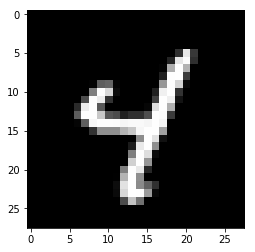

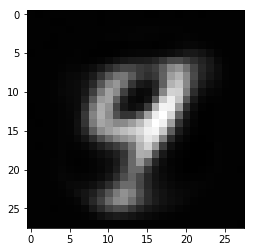

In [29]:
predict_random(test_X_scaled, test_pixels)

In [845]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10)
kmeans_model.fit(train_X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [867]:
hidden_kmeans = KMeans(n_clusters=10)
hidden_kmeans.fit(forward_propagate_layer(weights, train_X_scaled, 3))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [847]:
def get_eval(kmeans_model):
    from math import log2

    def calc_entropy(val_counts):
        res = 0
        n = val_counts.sum()
        for v in val_counts:
            res += -v/n * log2(v/n)
        return res

    raw_labels = kmeans_model.labels_
    avg_entropy = 0
    for i in range(10):
        val_counts = pd.Series(train_y_0)[raw_labels == i].value_counts()
        plt.bar(val_counts.index, val_counts)
        avg_entropy += calc_entropy(val_counts)
    plt.show()
    print('Average entropy is %.4f' % (avg_entropy/10))

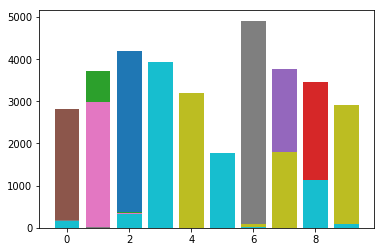

Average entropy is 1.5804


In [868]:
get_eval(kmeans_model)

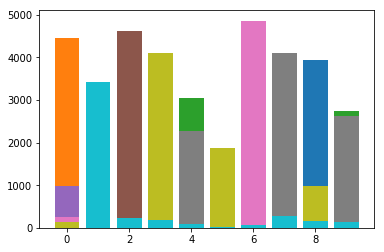

Average entropy is 1.4551


In [869]:
get_eval(hidden_kmeans)

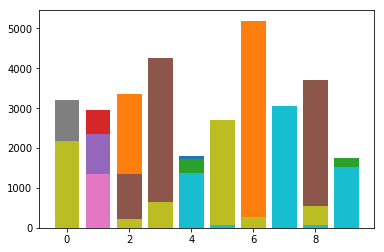

Average entropy is 1.7948


In [866]:
from math import log2

def calc_entropy(val_counts):
    res = 0
    n = val_counts.sum()
    for v in val_counts:
        res += -v/n * log2(v/n)
    return res

raw_labels = closest_centers_idx(forward_propagate_layer(weights, train_X_scaled, 3), centers[:, :-1])
avg_entropy = 0
for i in range(10):
    val_counts = pd.Series(train_y_0)[raw_labels == i].value_counts()
    plt.bar(val_counts.index, val_counts)
    avg_entropy += calc_entropy(val_counts)
plt.show()
print('Average entropy is %.4f' % (avg_entropy/10))

### Try TSNE
* Much better performance

In [876]:
from sklearn.manifold import TSNE

In [887]:
tsne = TSNE()
start = time()
test_tsne = tsne.fit_transform(test_X_scaled)
time()-start

3567.1715908050537

In [888]:
tsne_kmeans = KMeans(n_clusters=10)
tsne_kmeans.fit(test_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

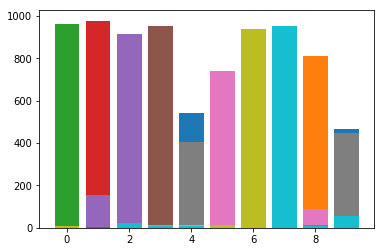

Average entropy is 0.7480


In [889]:
from math import log2

def calc_entropy(val_counts):
    res = 0
    n = val_counts.sum()
    for v in val_counts:
        res += -v/n * log2(v/n)
    return res

raw_labels = tsne_kmeans.labels_
avg_entropy = 0
for i in range(10):
    val_counts = pd.Series(test_y_0)[raw_labels == i].value_counts()
    plt.bar(val_counts.index, val_counts)
    avg_entropy += calc_entropy(val_counts)
plt.show()
print('Average entropy is %.4f' % (avg_entropy/10))

### PCA

In [890]:
from sklearn.decomposition import PCA

In [904]:
pca = PCA(n_components=10)

In [905]:
pca_out = pca.fit_transform(test_X_scaled)

In [906]:
pca_kmeans = KMeans(n_clusters=10)
pca_kmeans.fit(pca_out)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

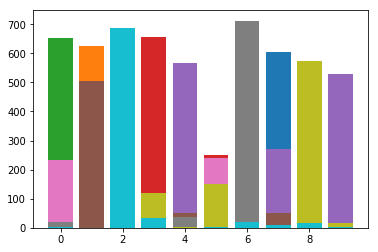

Average entropy is 1.6567


In [907]:
from math import log2

def calc_entropy(val_counts):
    res = 0
    n = val_counts.sum()
    for v in val_counts:
        res += -v/n * log2(v/n)
    return res

raw_labels = pca_kmeans.labels_
avg_entropy = 0
for i in range(10):
    val_counts = pd.Series(test_y_0)[raw_labels == i].value_counts()
    plt.bar(val_counts.index, val_counts)
    avg_entropy += calc_entropy(val_counts)
plt.show()
print('Average entropy is %.4f' % (avg_entropy/10))